<a href="https://colab.research.google.com/github/basturkme/4IER-HMI/blob/main/emgSignalTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating mock EMG data...
Data shape: (200, 1000, 1), Labels shape: (200,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Starting training...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5860 - loss: 0.5900 - val_accuracy: 1.0000 - val_loss: 0.1689
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 0.1300 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.0209 - val_accuracy: 1.0000 - val_loss: 7.5670e-05
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 1.8736e-05
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 1.0000 - loss: 2.9731e-04 - val_accuracy: 1.0000 - val_loss: 1.0457e-05
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 1.0000 - loss: 2.6046e-04 - val_accuracy: 1.0000 - val_loss: 7.4617e-06
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 2.1002e-04 - val_accuracy: 1.0000 - val_loss: 5.8357e-06
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accu

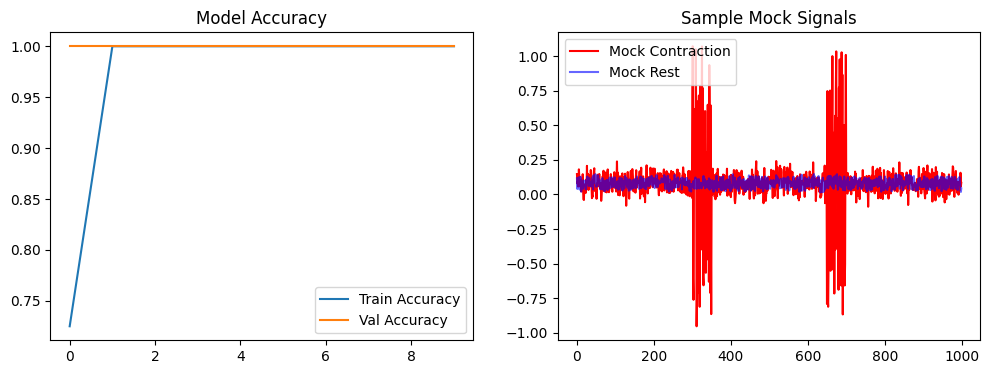

In [5]:
import numpy as np
import neurokit2 as nk
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
FS = 1000            # Sampling rate (Hz)
DURATION = 1         # Duration of each mock sample (seconds)
N_SAMPLES = 200      # Total number of mock data points to generate
NUM_CLASSES = 2      # Class 0: Rest, Class 1: Contraction

# --- 2. GENERATE MOCK DATA ---
print("Generating mock EMG data...")
X = []
y = []

for i in range(N_SAMPLES):
    # Randomly decide if this sample is "Rest" (0) or "Contraction" (1)
    label = np.random.randint(0, NUM_CLASSES)

    if label == 0:
        # Simulate "Rest": Low amplitude, just noise
        signal = nk.emg_simulate(duration=DURATION, sampling_rate=FS,
                                 burst_number=0, noise=0.01)
    else:
        # Simulate "Contraction": High amplitude bursts
        # We vary burst_number to make the model learn generalized patterns
        n_bursts = np.random.randint(1, 4)
        signal = nk.emg_simulate(duration=DURATION, sampling_rate=FS,
                                 burst_number=n_bursts, burst_duration=0.05, noise=0.05) # Reduced burst_duration

    X.append(signal)
    y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape for the Neural Network: (Samples, Time Steps, Features)
# A 1D CNN expects the last dimension to be the number of channels (1 for single-channel EMG)
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# --- 3. PREPROCESSING ---
# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. DEFINE MODEL (1D CNN) ---
# A 1D Convolutional Neural Network is excellent for raw time-series biosignals
model = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=(FS * DURATION, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), # Prevents overfitting on small mock datasets
    layers.Dense(1, activation='sigmoid') # Binary classification output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- 5. TRAIN MODEL ---
print("\nStarting training...")
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# --- 6. VISUALIZE RESULTS ---
# Plot training accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot a sample signal
plt.subplot(1, 2, 2)
plt.plot(X[np.where(y==1)[0][0]], color='red', label="Mock Contraction")
plt.plot(X[np.where(y==0)[0][0]], color='blue', alpha=0.6, label="Mock Rest")
plt.title('Sample Mock Signals')
plt.legend()
plt.show()

In [3]:
!pip install neurokit2

In [6]:
import scipy.io

# Replace with your actual filename
mat_contents = scipy.io.loadmat('S7_A1_E1.mat')

print("Keys found in the MATLAB file:")
print(mat_contents.keys())


Keys found in the MATLAB file:
dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])


In [7]:
import scipy.io
from scipy import stats

# --- 2. LOAD & WINDOW REAL DATA ---
print("Loading and segmenting continuous MATLAB data...")

# 1. Load the File
mat_data = scipy.io.loadmat('S7_A1_E1.mat') # Changed filename from 'my_emg_data.mat' to 'S7_A1_E1.mat'

# 2. Extract Signals
# 'emg' is usually (TimePoints, Channels) -> e.g., (100000, 10)
# 'stimulus' is the label for each time point -> e.g., (100000, 1)
raw_emg = mat_data['emg']
raw_stimulus = mat_data['stimulus']

print(f"Original EMG shape: {raw_emg.shape}")
print(f"Original Stimulus shape: {raw_stimulus.shape}")

# 3. Define Windowing Parameters
# A 4th-year EE note: We need overlapping windows to capture transitions.
WINDOW_SIZE = 200   # Window length in samples (e.g., 200ms if FS=1000Hz)
STRIDE = 100        # Step size (50% overlap)

X_windows = []
y_windows = []

# 4. Perform Sliding Window Segmentation
# We iterate through the continuous signal and slice it
for i in range(0, len(raw_emg) - WINDOW_SIZE, STRIDE):
    # Slice the EMG data
    window_data = raw_emg[i : i + WINDOW_SIZE, :]

    # Slice the labels
    window_label_seq = raw_stimulus[i : i + WINDOW_SIZE]

    # Determine the label for this window:
    # We use the mode (most frequent label) in this segment
    # .item() converts the result to a standard Python integer
    label_mode = stats.mode(window_label_seq, axis=None, keepdims=False)[0]

    X_windows.append(window_data)
    y_windows.append(label_mode)

# 5. Convert to Numpy Arrays
X = np.array(X_windows)
y = np.array(y_windows)

# 6. Binary Classification Adjustment (Optional)
# If you only want "Rest vs. Move", we set all non-zero labels to 1.
# Stimulus 0 usually = Rest. Stimulus 1,2,3... = Different movements.
y_binary = np.where(y == 0, 0, 1)

# Update the global label variable to use the binary version
y = y_binary

# X is now (N_Windows, Window_Size, N_Channels)
print(f"Segmented Data Shape: {X.shape}")
print(f"Segmented Label Shape: {y.shape}")

# CRITICAL UPDATE FOR SECTION 4 (MODEL DEFINITION):
# You must update input_shape in the Conv1D layer to match X.shape[1] and X.shape[2]
INPUT_SHAPE = (X.shape[1], X.shape[2])
print(f"Update your model input_shape to: {INPUT_SHAPE}")

Loading and segmenting continuous MATLAB data...


FileNotFoundError: [Errno 2] No such file or directory: 'my_emg_data.mat'